In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Large Angle Pendula

we will try to numerically simulate using Euler's method a pendulum that begins displaced from its mean position. The pendulum is allowed to be displaced however much as opposed to a simple harmonic pendulum that only allows small angle displacements. We can learn what to expect by looking at the mechanics before simulating it.

## The Mechanics

Consider the free body diagram of the pendulum below with the forces acting on it

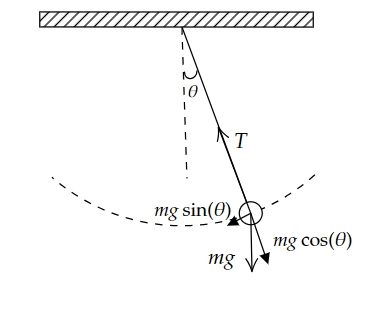

The only two forces acting on the pendulum are tension and gravity and they work together so that the pendulum moves in a circle. Now, the gravitational force acting onthe bob can be resolved into two components, one along the the direction of the bob (tangential) and then radial.

We need the forces in the radial direction to provide us the centripetal force the bob requires to move in the circle.
The component of gravity that's tangential to the circle the bob moves in is what speeds up or slows the bob down as it moves in the circle it describes

From these two considerations, we can set up the following equations,

radial drection: $$ m{\omega}^2l = T - mg\cos(\theta) $$
tangential direction: $$ ml\ddot{\theta} = -mg\sin(\theta) $$

We won't quite care about the first equation since that's in the radial direction and angular displacements happen along the tangential direction. There is also no radial movement since the string is taut. 

In the tangential direction, the angle is governed by the second equation. Rearranged with cancellations, the equation is

$$ \ddot{\theta} = - \frac{g}{l}\sin{\theta} $$

This is precisely the differential equation we want to numerically solve to obtain the behaviour of the pendulum. The impact a computer has in helping with differential equations is described pretty well by the case of the large angle pendulum as the equation above is not very easy to solve. However, a computer can numerically update its state until we have a simulated picture of the entire story. 

When $\theta$ is sufficiently small, $\sin{\theta} \approx \theta$ and the equation becomes $$ \ddot{\theta} = - \frac{g}{l} \theta$$

The solution to this equation is the familiar $ x = A\cos{(\omega t + \phi)}$ where $\omega = \sqrt{\frac{g}{l}} $ 

The large angle pendulum like the pendulum with the small angle approx is also periodic however it is no longer sinusoidal. A noteworthy difference between the
large angle pendulum and the small angle is that, while the time period of a small angle pendulum is independant of where u let the pendulum bob go, the time period of a
large angle pendulum is not. We'll focus the simulation around this aspect and see exactly how it varies with initial angles

### Time period of the penduluum

It is easy for the small angle case.

The cosine of the solution must return to a value it previously was if you wait the time period, $T$. 

So, $$ \cos(\omega (t+T)) = \cos(\omega t) $$

$$\omega T = 2\pi $$
$$ T = \frac{2\pi}{\omega} $$
$$ T = 2\pi\sqrt{\frac{l}{g}} $$

For a large angle pendulum, it is more complicated. We don't have a function for the angular displacement where we can read the time period from. In fact, finding the
angular displacement as a function of time will be much harder than finding the time period.

Luckily, the conservation of energy saves the day!

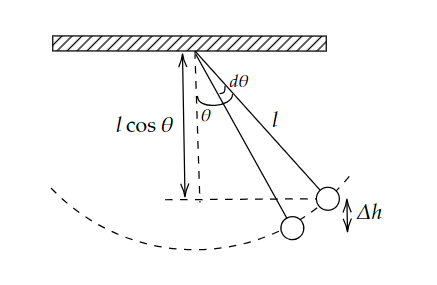

At the initial angle, $\theta_0$, the bob is left. It has gravitational potential energy but no kinetic energy. At all times after, it has some kinetic energy and some gravitational
potential energy. Since there is no work done on the system from "outside", the mechanical energy is conserved and I can write this equation down:

$$ -mgl\cos{\theta_0} = -mgl\cos{\theta}+\frac{1}{2}m\omega^{2}l^2 $$

Rearrange and make $\omega$ the subject to find $$ \omega = \sqrt{\frac{2g}{l}}\sqrt{\cos{\theta}-\cos{\theta_0}} $$


And since $\omega$ is $\frac{d\theta}{dt}$
$$ \frac{d\theta}{dt} = \sqrt{\frac{2g}{l}}\sqrt{\cos{\theta}-\cos{\theta_0}} $$

Observe that $\frac{d\theta}{dt} dt$ gives u the angle moved by the pendulum for $dt$ seconds (the exact value depends on what the current value of $\theta$ is, hence why it's a function of $\theta$ )
but if we're looking for the time taken by the pendulum, it is wiser to measure the time taken for angle shifts of $d\theta$. What do we do? literally just...

$$ \frac{dt}{d\theta} d\theta = \sqrt{\frac{l}{2g}}\frac{1}{\sqrt{\cos{\theta}-\cos{\theta_0}}} d\theta$$

So, to find the time taken by the pendulum to move, you sum up the time taken per $d\theta$ shift for all values of $\theta$ that lie in your concerned interval.
That is called an integral.

$$\Delta t = \int_{\theta}^{\theta + \Delta \theta}{\sqrt{\frac{l}{2g}}\frac{1}{\sqrt{\cos{\theta}-\cos{\theta_0}}}} d\theta $$

and for the time period it is
$$T = 4 \int_{0}^{\theta_0}{\sqrt{\frac{l}{2g}}\frac{1}{\sqrt{\cos{\theta}-\cos{\theta_0}}}} d\theta $$

(we're integrating over a quarter cycle and multiplying by 4)

This integral cannot be solved in terms of elementary functions and the only way to solve it is to do it numerically. It is ironic because, after all, the numeric way
is by definition what an integral is

Let's run a code that will plot for us the graph of the variation of the time period with initial angles

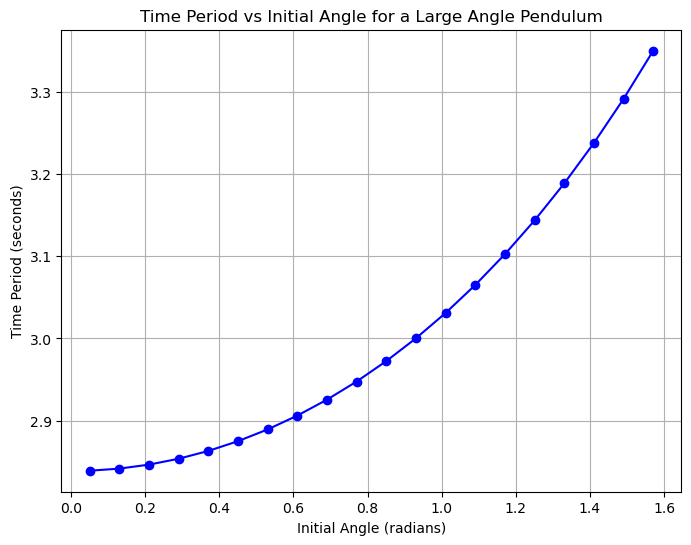

In [8]:
from scipy.integrate import quad

#Constants
g = 9.8  #gravitational acc. 
L = 1.0   #length

#function that computes the integrand for the period
def integrand(theta, theta_0):
    return 1.0 / np.sqrt(np.cos(theta) - np.cos(theta_0))

#computes the time period for given initial angle theta_0
def calculate_period(theta_0):
    #quad function computes the integral
    integral, _ = quad(integrand, 0, theta_0, args=(theta_0,))
    period = 4*np.sqrt(L/g)*integral
    return period

#preps the domain
initial_angles = np.linspace(0.05, np.pi/2, 20)  #0.05 to prevent division by zero
periods = []

#calculates the preiod from the integral and adds to the list for every angle in the domain
for theta_0 in initial_angles:
    period = calculate_period(theta_0)
    periods.append(period)

#plot stuff
plt.figure(figsize=(8, 6))
plt.plot(initial_angles, periods, marker='o', linestyle='-', color='b')
plt.title("Time Period vs Initial Angle for a Large Angle Pendulum")
plt.xlabel("Initial Angle (radians)")
plt.ylabel("Time Period (seconds)")
plt.grid(True)
plt.show()

From the graph, we learn that the time period increases as the amplitude of the pendulum increases. Can you guess why? What value of the time period do you think
the graph starts from?

## The Simulation

What we did so far is no where near what a simulation is. We just numerically solved an integral. In a simulation, all that is mentioned is the force law.
There is no human intervention in the swinging of the pendulum. Similarly, the computer just updates to the next state given what the previous state is just like real life.
Of course, this is just euler's method.

Begin by setting the stage. Add gravity to your space, define the size of your infinitesimal time step and create a timeline

In [3]:
g = 9.8
dt = 10**(-5) #small enough?
t = np.arange(0, 30, dt)  #timeline
n = len(t)  #number of steps(useful later)

We can now bring the pendulum in. Our pendulum object has:
- mass
- length

and carries information of
- angle with vertical; initial angle
- angular velocity; initial ang. velocity
- angular acceleration

Therefore to define the pendulum, we have to create variables for mass and length and arrays for angle, angular velocity and angular acceleration. We can then perform euler's method
over them like in my previous project about euler method examples available on my github.

However, we can think a step ahead and define a <b>class</b>. That allows us to make a second pendulum or as many pendulums as we need. The pendulum can then be an <b>object</b>
which is just an <b>instance of that class</b>. A class is just a notion of what the object fundamentally is and what <b>characteristics it fundamentally possesses</b>. So, once I make
a class, I no longer have to tell the second pendulum what to do because every pendulum that is an instance of the class behaves the way the class <b>intends for you to do.</b>

In [4]:
class LargeAngPend:
    def __init__(self, mass, leng): #init function tells the program to make your pendulum with the mass and length you provide as arguments
        self.mass = mass
        self.leng = leng
    
    def run(self, initAng, initVel): #this function contains the euler's method
        
        # Preallocate arrays as 0, and change values as we go. It's just easier on the computer than appending as it will have to change memory size each time.
        
        x = np.zeros(n)  # Angular displacement
        v = np.zeros(n)  # Angular velocity
        a = np.zeros(n)  # Angular acceleration
        
        # Euler's Method
        x[0] = initAng
        v[0] = initVel
        a[0] = -g*np.sin(x[0])
        
        for i in range(n-1):
            v[i+1] = v[i]+a[i]*dt
            x[i+1] = x[i]+v[i]*dt
            a[i+1] = -(g/self.leng)*np.sin(x[i+1])
        
        self.position = x
        self.velocities = v
        self.acc = a
        
        # Records each time the pendulum crosses mean position
        self.T = []  # Reset T for each pendulum run
        for i in range(1, n):
            if (x[i] > 0 and x[i-1] < 0):
                self.T.append(t[i])
        
    def getTimePeriod(self):
        if len(self.T)<2:
            print("hasn't finished a cycle yet")
            return None  # Not enough data for period calculation
        
        # Calculate the time period using the zero-crossing times
        TP = (self.T[len(self.T)-1] - self.T[0]) / (len(self.T) - 1)
        return TP

This long code defines the class and contains instructions about the object. It's easier to understand how it works inside when we create a pendulum object

In [5]:
PendA = LargeAngPend(2,2) #pendulum of mass 2kg and length 2m
PendA.run(np.pi/3,0) #released at 60 deg with 0 angular velocity

An object PendA is created. The moment the program sees a request for the creation, it calls the init function in the class. It takes the specified mass and length
and creates the pendulum object named PendA. Then the run function takes in information about starting angle and the initial angular velocity. Euler's method is contained
inside the run function, with all the arrays defined inside it. When the run function is called, it updates all the arrays accordingly. In other words, every pendulum object
comes with its run funciton that accesses the code defined in the class when you need it to run.

We can see the plot of PendA with time to see how the motion should look like.

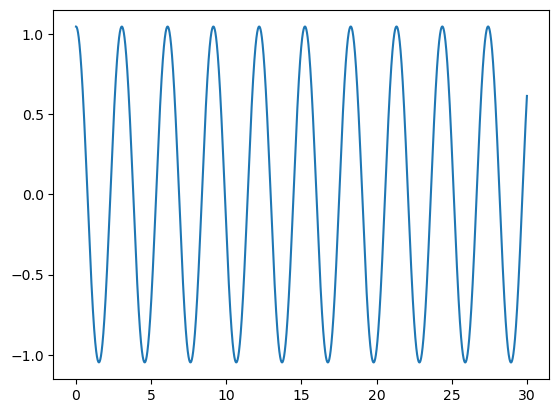

In [6]:
plt.plot(t,PendA.position)

It looks like it is just a sinusoidal curve but it is not. The reason it looks similar is because it is after all a pendulum, it more or less "swings" a similar way

To find the time period of this pendulum, if you noticed, there is a <b>getTimePeriod()</b> function defined inside the class. Just like the run function, when this is
executed, it calculates and tells us the time period.
    
The logic of this function is important. To find the time period of the pendulum, you mark a spot and wait till the bob crosses it in the same direction again. An easy choice would be the mean position, zero. To do just that, the run() function contains also a seperate array that detects the bob crossing zero and notes the time it does so. There's a catch! Since our system is discrete, I can't just simply say <i>"when PendA.position = 0, note time"</i> because there might just not be 0. Although our steps are small enough, the limitation is that it is not infinitesimal. Therefore, we detect for changes in sign and we can pretend that the bob crossed 0 on its way. You can have a sign change of -+ or +-, pick only one and you have accounted for direction as well.

When you call the getTimePeriod() function, it uses the zero-crossing array made by the run() function and treats the array elements as terms of an arithmetic progression and calculates the common difference. The common difference is the time period reported back.

In [7]:
print(PendA.getTimePeriod())

3.046337777777778


If you wish, you can create a second object PendB and you will realise you don't need to define seperate variables for it or rewrite the code to handle B this time
(imagine having arrays xA, xB, xC and so on with an euler's method for each of them!). Classes greatly simplify this issue.

To plot the variation of the time period with intial angles, we need to first obtain the time period of the pendulum for every intial angle. Therefore, by right, it is required
that we call the run() finction each time with a different inital angle and then call the getTimePeriod() function. This will cause the program to run euler's method again and again.

We can escape this using the concept of threads which executes by sharing resources these repetitive tasks at the same time. However, the idea is the same.

In [10]:
from concurrent.futures import ThreadPoolExecutor

initangles = np.linspace(0, np.pi/2, 20) #prep the domain

def calculate_period(init_ang):
    Pend = LargeAngPend(1, 1)
    Pend.run(init_ang, 0)
    return Pend.getTimePeriod()

#run the simulations in parallel and get time periods
with ThreadPoolExecutor() as executor:
    T = list(executor.map(calculate_period, initangles))

hasn't finished a cycle yet


All that's left is to plot the array of the time period values vs the values of the intial angle. We should get the following output.

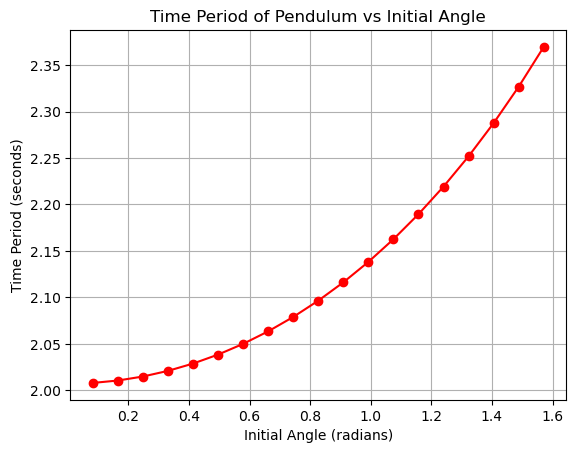

In [12]:
plt.plot(initangles, T, marker='o', color='red')
plt.title('Time Period of Pendulum vs Initial Angle')
plt.xlabel('Initial Angle (radians)')
plt.ylabel('Time Period (seconds)')
plt.grid(True)
plt.show()

This is of course a graph that is very similar to the one obtained from numeric integration. However, the graph just obtained is the result of pure simulation. It is as if
we asked the computer to sit with a stop watch and time the pendulum. This is like a digital version of <i> "let the experiment verify the theory" </i> and as we can see,
the "experimental" measurement does verify the integral we came up with.